# Visualizing Population Based Training (PBT) Hyperparameter Optimization

**Assumptions:** The reader has a basic understanding of the [PBT algorithm](https://www.deepmind.com/blog/population-based-training-of-neural-networks) and wants to dive deeper and verify the underlying algorithm behavior with [Ray's PBT implementation](tune-scheduler-pbt). [This guide](pbt-guide-ref) provides resources for gaining some context.

Population Based Training (PBT) is a powerful technique that combines parallel search with sequential optimization to efficiently find optimal hyperparameters. Unlike traditional hyperparameter tuning methods, PBT dynamically adjusts hyperparameters during training by having multiple training runs ("trials") that evolve together, periodically replacing poorly performing configurations with perturbations of better ones.

This tutorial will go through a simple example that will help you develop a better understanding of what PBT is doing under the hood when using it to tune your algorithms.

We will learn how to:

1. **Set up checkpointing and loading for PBT** with the function trainable interface
2. **Configure Tune and PBT scheduler parameters**
3. **Visualize PBT algorithm behavior** to gain some intuition

## Set up Toy the Example

The toy example optimization problem we will use comes from the [PBT paper](https://arxiv.org/pdf/1711.09846.pdf) (see Figure 2 for more details). The goal is to find parameters that maximize an quadratic function, while only having access to an estimator that depends on a set of hyperparameters. A practical example of this is maximizing the (unknown) generalization capabilities of a model across all possible inputs with only access to the empirical loss of your model, which depends on hyperparameters in order to optimize.

We'll start with some imports.

In [1]:
!pip install -q -U "ray[tune]" matplotlib

Note: this tutorial imports functions from {doc}`this helper file </tune/examples/pbt_visualization/pbt_visualization_utils>` named `pbt_visualization_utils.py`. These define plotting functions for the PBT training progress.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import tempfile

import ray
from ray import tune
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.tune_config import TuneConfig
from ray.tune.tuner import Tuner

from pbt_visualization_utils import (
    get_init_theta,
    plot_parameter_history,
    plot_Q_history,
    make_animation,
)


2025-02-24 15:55:09,029	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-24 15:55:09,208	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Concretely, we will use the definitions (with very minor modifications) provided in the [paper](https://arxiv.org/pdf/1711.09846.pdf) for the function we are trying to optimize, and the estimator we are given.

Our goal is to maximize a quadratic function `Q`, but we only have access to a biased estimator `Qhat` that depends on hyperparameters. This simulates real-world scenarios where we want to optimize for true generalization performance but can only measure training performance, which is influenced by hyperparameters.


Here is a list of the concepts we will use for the example, and what they might be analagous to in practice:

| Symbol | In This Example | Real-World Analogy |
|---------|-------------|-------------------|
|`theta = [theta0, theta1]`| Model parameters, updated in each training step.|Neural network parameters|
|`h = [h0, h1]`| The hyperparameters optimized by PBT. | Learning rate, batch size, etc.|
|`Q(theta)`| **True reward function** we *want* to optimize, but is not directly use for training.|**True generalization**-- an theoretical and unobersvable in practice.|
|`Qhat(theta \| h)`| **Estimated reward function** we actually optimize against; depends on the hyperparameters as well as the model parameters.|**Empirical reward** in training.|
|`grad_Qhat(theta \| h)`| Gradient of the estimated reward function, used to update model parameters | Gradient descent step in training | 

Below are the implementations in code.

In [3]:
def Q(theta):
    # equation for an elliptic paraboloid with a center at (0, 0, 1.2)
    return 1.2 - (3 / 4 * theta[0] ** 2 + theta[1] ** 2)


def Qhat(theta, h):
    return 1.2 - (h[0] * theta[0] ** 2 + h[1] * theta[1] ** 2)


def grad_Qhat(theta, h):
    theta_grad = -2 * h * theta
    theta_grad[0] *= 3 / 4
    h_grad = -np.square(theta)
    h_grad[0] *= 3 / 4
    return {"theta": theta_grad, "h": h_grad}


theta_0 = get_init_theta()
print(f"Initial parameter values: theta = {theta_0}")


Initial parameter values: theta = [0.9 0.9]


## Defining the Function Trainable

We will define the training loop:
1. Load the hyperparameter configuration
2. Initialize the model, **resuming from a checkpoint if one exists (this is important for PBT, since the scheduler will pause and resume trials frequently when trials get exploited).**
3. Run the training loop and **checkpoint.**

In [4]:
def train_func(config):
    # Load the hyperparam config passed in by the Tuner
    h0 = config.get("h0")
    h1 = config.get("h1")
    h = np.array([h0, h1]).astype(float)

    lr = config.get("lr")
    train_step = 1
    checkpoint_interval = config.get("checkpoint_interval", 1)

    # Initialize the model parameters
    theta = get_init_theta()

    # Load a checkpoint if it exists
    # This checkpoint could be a trial's own checkpoint to resume,
    # or another trial's checkpoint placed by PBT that we will exploit
    checkpoint = tune.get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            with open(os.path.join(checkpoint_dir, "checkpoint.pkl"), "rb") as f:
                checkpoint_dict = pickle.load(f)
        # Load in model (theta)
        theta = checkpoint_dict["theta"]
        last_step = checkpoint_dict["train_step"]
        train_step = last_step + 1

    # Main training loop (trial stopping is configured later)
    while True:
        # Perform gradient ascent steps
        param_grads = grad_Qhat(theta, h)
        theta_grad = np.asarray(param_grads["theta"])
        theta = theta + lr * theta_grad

        # Define which custom metrics we want in our trial result
        result = {
            "Q": Q(theta),
            "theta0": theta[0],
            "theta1": theta[1],
            "h0": h0,
            "h1": h1,
            "train_step": train_step,
        }

        # Checkpoint every `checkpoint_interval` steps
        should_checkpoint = train_step % checkpoint_interval == 0
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if should_checkpoint:
                checkpoint_dict = {
                    "h": h,
                    "train_step": train_step,
                    "theta": theta,
                }
                with open(
                    os.path.join(temp_checkpoint_dir, "checkpoint.pkl"), "wb"
                ) as f:
                    pickle.dump(checkpoint_dict, f)
                checkpoint = tune.Checkpoint.from_directory(temp_checkpoint_dir)

            # Report metric for this training iteration, and include the
            # trial checkpoint that contains the current parameters if we
            # saved it this train step
            tune.report(result, checkpoint=checkpoint)

        train_step += 1


```{note}
Since PBT will keep restoring from latest checkpoints, it's important to save and load `train_step` correctly in a function trainable. **Make sure you increment the loaded `train_step` by one as shown above in `checkpoint_dict`.** This avoids repeating an iteration and causing the checkpoint and perturbation intervals to be out of sync.

```

## Configure PBT and Tuner

We start by initializing ray (shutting it down if a session existed previously).

In [5]:
if ray.is_initialized():
    ray.shutdown()
ray.init()


2025-02-24 15:55:09,853	INFO worker.py:1841 -- Started a local Ray instance.


Python version:,3.11.11
Ray version:,2.42.1


### Create the PBT scheduler

In [6]:
perturbation_interval = 4

pbt_scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    metric="Q",
    mode="max",
    quantile_fraction=0.5,
    resample_probability=0.5,
    hyperparam_mutations={
        "lr": tune.qloguniform(5e-3, 1e-1, 5e-4),
        "h0": tune.uniform(0.0, 1.0),
        "h1": tune.uniform(0.0, 1.0),
    },
    synch=True,
)


A few notes on the PBT config:
- `time_attr="training_iteration"` in combination with `perturbation_interval=4` will decide whether a trial should continue or exploit a different trial every 4 training iterations.
- `metric="Q"` and `mode="max"` specify how trial performance is ranked. In this case, the high performing trials are the top 50% of trials (set by `quantile_fraction=0.5`) that report the highest `Q` metrics. Note that we could have set the metric/mode in `TuneConfig` instead.
- `hyperparam_mutations` specifies that the learning rate `lr` and additional hyperparameters `h0`, `h1` should be perturbed by PBT and defines the resample distribution for each hyperparameter (where `resample_probability=0.5` means that resampling and mutation both happen with 50% probability).
- `synch=True` means that PBT will run synchronously, which slows down the algorithm by introducing waits, but it produces more understandable visualizations for the purposes of this tutorial.
    - In synchronous PBT, we wait until **all trials** reach the next `perturbation_interval` to decide which trials should continue and which trials should pause and start from the checkpoint of another trials. In the case of 2 trials, this means that every `perturbation_interval` will result in the worse performing trial exploiting the better performing trial.
    - This is not always the case in asynchronous PBT, since trials report results and decide whether to continue or exploit **one by one**. This means that a trial could decide that it is a top-performer and decide to continue, since other trials haven't had the chance to report their better results yet. Therefore, we do not always see trials exploiting on every `perturbation_interval`.

### Create the Tuner

In [7]:
tuner = Tuner(
    train_func,
    param_space={
        "lr": 0.05,
        "h0": tune.grid_search([0.0, 1.0]),
        "h1": tune.sample_from(lambda spec: 1.0 - spec.config["h0"]),
        "num_training_iterations": 100,
        # Match `checkpoint_interval` with `perturbation_interval`
        "checkpoint_interval": perturbation_interval,
    },
    tune_config=TuneConfig(
        num_samples=1,
        # Set the PBT scheduler in this config
        scheduler=pbt_scheduler,
    ),
    run_config=tune.RunConfig(
        stop={"training_iteration": 100},
        failure_config=tune.FailureConfig(max_failures=3),
    ),
)


```{note}
We recommend matching `checkpoint_interval` with `perturbation_interval` from the PBT config.
This ensures that the PBT algorithm actually exploits the trials in the most recent iteration.

If your `perturbation_interval` is large and want to checkpoint more frequently, set `perturbation_interval` to be a multiple of `checkpoint_interval`.
```

A few other notes on the Tuner config:
- `param_space` specifies the *initial* `config` input to our training function. A `grid_search` over two values will launch two trials with a certain set of hyperparameters, and PBT will continue modifying them as training progresses.
- The initial hyperparam settings for `h0` and `h1` are configured so that two trials will spawn, one with `h = [1, 0]` and the other with `h = [0, 1]`. This matches the paper experiment and will be used to compare against a `grid_search` baseline that removes the PBT scheduler.

## Run the experiment

We launch the trials by calling `Tuner.fit`.

In [8]:
pbt_results = tuner.fit()


2025-02-24 15:55:10,326	WARNING sample.py:469 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-02-24 15:55:10,327	WARNING sample.py:469 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-02-24 15:55:11,300	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial c80b3_00000 (score = 0.243822) into trial c80b3_00001 (score = 0.064403)

2025-02-24 15:55:11,301	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trialc80b3_00001:
lr : 0.05 --- (* 0.8) --> 0.04000000000000001
h0 : 0.0 --- (resample) --> 0.3752033170573623
h1 : 1.0 --- (resample) --> 0.5906277125915594

2025-02-24 15:55:12,092	WARNING logger.py:186 -- Remote file not found: /Users/rdecal/ray_results/train_func_2025-02-24_15-55-10/train_func_c80b3_00000_0_h0=0.0000_2025-02-24_15-55-10/result.json
2025

(train_func pid=13493) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/rdecal/ray_results/train_func_2025-02-24_15-55-10/train_func_c80b3_00000_0_h0=0.0000_2025-02-24_15-55-10/checkpoint_000000)
(train_func pid=13496) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/Users/rdecal/ray_results/train_func_2025-02-24_15-55-10/train_func_c80b3_00000_0_h0=0.0000_2025-02-24_15-55-10/checkpoint_000000)
(train_func pid=13516) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/rdecal/ray_results/train_func_2025-02-24_15-55-10/train_func_c80b3_00000_0_h0=0.0000_2025-02-24_15-55-10/checkpoint_000004) [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(train_func pid=13518) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem

## Visualize results

Using some helper functions {doc}`from here </tune/examples/pbt_visualization/pbt_visualization_utils>`, we can create some visuals to help us understand the training progression of PBT.

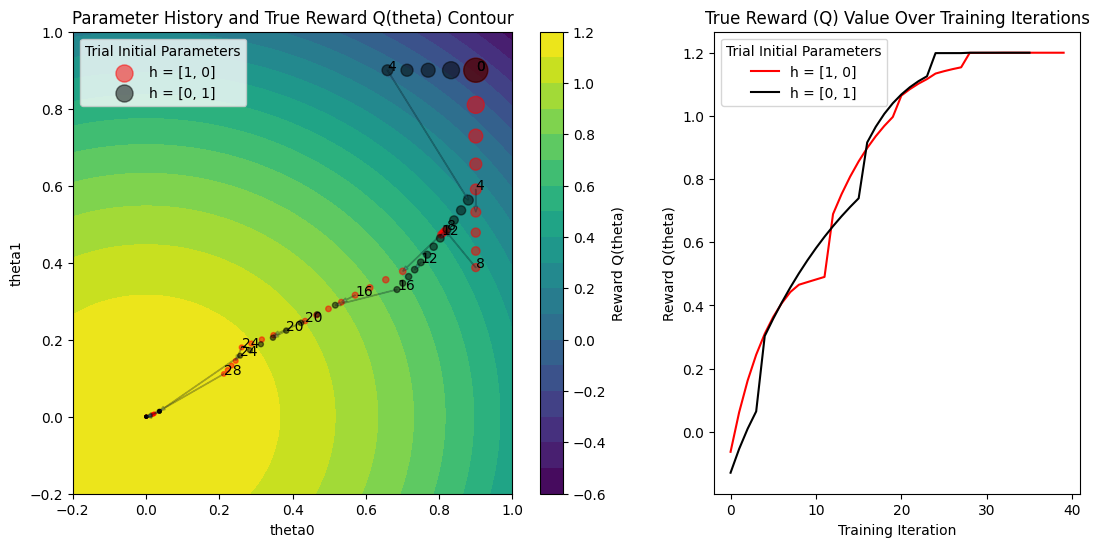

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6), gridspec_kw=dict(width_ratios=[1.5, 1]))

colors = ["red", "black"]
labels = ["h = [1, 0]", "h = [0, 1]"]

plot_parameter_history(
    pbt_results,
    colors,
    labels,
    perturbation_interval=perturbation_interval,
    fig=fig,
    ax=axs[0],
)
plot_Q_history(pbt_results, colors, labels, ax=axs[1])


The plot on the right shows the true function value `Q(theta)` as training progresses for both trials. Both trials reach the maximum value of `1.2`.

Here's how to understand the plot on the left:
- The plot on the left shows the parameter values `(theta0, theta1)` on every training iteration, for both trials. As the training iteration increases, the size of the point gets smaller.
- We see the iteration shown as a label next to points at every `perturbation_interval` training iterations. Let's zoom into the transition from iteration 4 to 5 for both the trials.
    - We see that a trial either **continues** (see how iteration 4 to 5 for the red trial just continues training) or **exploits and perturbs the other trial and then performs a train step** (see how iteration 4 to 5 for the black trial jumps to the parameter value of the red trial).
    - The gradient direction also changes at this step for the red trial due to the hyperparameters changing from the exploit and explore steps of PBT. Remember that the gradient of the estimator `Qhat` depends on the hyperparameters `(h0, h1)`.
    - The varying size of jumps between training iterations shows that the learning rate is also changing, since we included `lr` in the set of hyperparameters to mutate.

### Animate the training progress

In [10]:
make_animation(
    pbt_results,
    colors,
    labels,
    perturbation_interval=perturbation_interval,
    filename="pbt.gif",
)


We can also animate the training progress to see what's happening to the model parameters at each step.

![PBT Visualization GIF](pbt.gif)

## Grid Search Comparison

The paper includes a comparison to a grid search of 2 trials, using the same initial hyperparameter configurations (`h = [1, 0], h = [0, 1]`) as the PBT experiment. The only difference in the code below is removing the PBT scheduler from the `TuneConfig`. 

In [11]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

tuner = Tuner(
    train_func,
    param_space={
        "lr": tune.qloguniform(1e-2, 1e-1, 5e-3),
        "h0": tune.grid_search([0.0, 1.0]),
        "h1": tune.sample_from(lambda spec: 1.0 - spec.config["h0"]),
    },
    tune_config=tune.TuneConfig(
        num_samples=1,
        metric="Q",
        mode="max",
    ),
    run_config=tune.RunConfig(
        stop={"training_iteration": 100},
        failure_config=tune.FailureConfig(max_failures=3),
    ),
)

grid_results = tuner.fit()
if grid_results.errors:
    raise RuntimeError


2025-02-24 15:55:59,270	WARNING sample.py:469 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-02-24 15:55:59,271	WARNING sample.py:469 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
(train_func pid=13727) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/rdecal/ray_results/train_func_2025-02-24_15-55-59/train_func_e5386_00000_0_h0=0.0000,lr=0.0400_2025-02-24_15-55-59/checkpoint_000000)
(train_func pid=13727) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/rdecal/ray_results/train_func_2025-02-24_15-55-59/train_func_e5386_00000_0_h0=0.0000,lr=0.0400_2025-02-24_15-55-59/checkpoint_000001)
(train_func pid=13727) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/rdecal/ray_results/train_func_2025-02-24_15-55-59/train_func_e5386_00000_0_h0=0.

As we can see, neither trial makes it to the optimum, since the hyperparameter configs are stuck with their original values.

(train_func pid=13728) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/rdecal/ray_results/train_func_2025-02-24_15-55-59/train_func_e5386_00001_1_h0=1.0000,lr=0.0500_2025-02-24_15-55-59/checkpoint_000083)
(train_func pid=13728) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/rdecal/ray_results/train_func_2025-02-24_15-55-59/train_func_e5386_00001_1_h0=1.0000,lr=0.0500_2025-02-24_15-55-59/checkpoint_000084)
(train_func pid=13728) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/rdecal/ray_results/train_func_2025-02-24_15-55-59/train_func_e5386_00001_1_h0=1.0000,lr=0.0500_2025-02-24_15-55-59/checkpoint_000085)
(train_func pid=13728) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/rdecal/ray_results/train_func_2025-02-24_15-55-59/train_func_e5386_00001_1_h0=1.0000,lr=0.0500_2025-02-24_15-55-59/checkpoint_000086)
(train_func pid=13728) Checkpoint successfully created at: Check

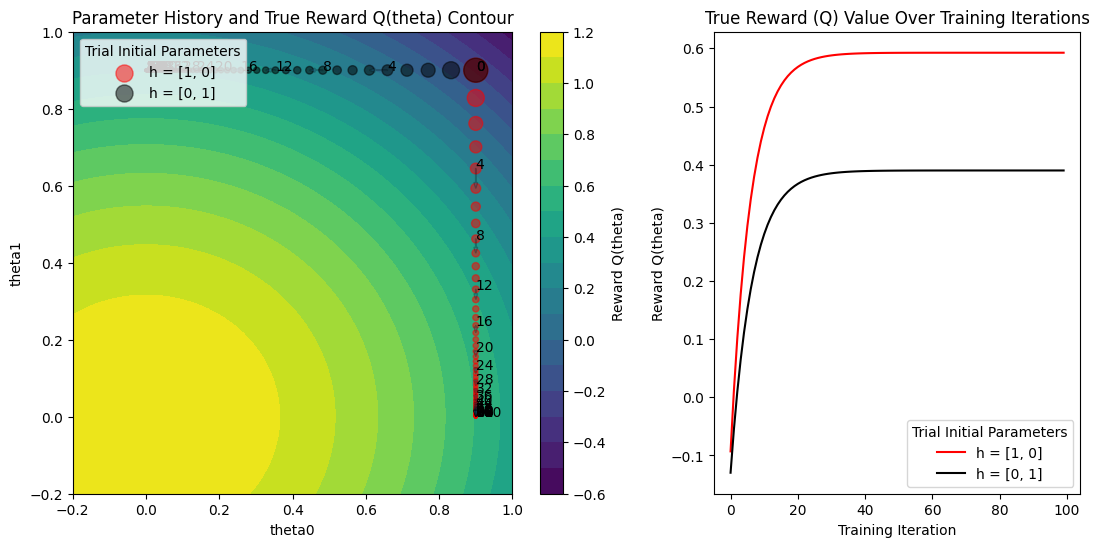

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6), gridspec_kw=dict(width_ratios=[1.5, 1]))

colors = ["red", "black"]
labels = ["h = [1, 0]", "h = [0, 1]"]

plot_parameter_history(
    grid_results,
    colors,
    labels,
    perturbation_interval=perturbation_interval,
    fig=fig,
    ax=axs[0],
)
plot_Q_history(grid_results, colors, labels, ax=axs[1])


Compare the two plots we generated with Figure 2 from the [PBT paper](https://arxiv.org/pdf/1711.09846.pdf) (in particular, we produced the top-left and bottom-right plots).

![Figure 2](figure_from_paper.png)

## Increase PBT population size

One last experiment: what does it look like if we increase the PBT population size? Now, low-performing trials will sample one of the multiple high-performing trials to exploit, and it should result in some more interesting behavior.

In [13]:
if ray.is_initialized():
    ray.shutdown()
ray.init()
perturbation_interval = 4
pbt_scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    quantile_fraction=0.5,
    resample_probability=0.5,
    hyperparam_mutations={
        "lr": tune.qloguniform(5e-3, 1e-1, 5e-4),
        "h0": tune.uniform(0.0, 1.0),
        "h1": tune.uniform(0.0, 1.0),
    },
    synch=True,
)
tuner = Tuner(
    train_func,
    param_space={
        "lr": tune.qloguniform(5e-3, 1e-1, 5e-4),
        "h0": tune.grid_search([0.0, 1.0, 0.01, 0.99]),  # 4 trials
        "h1": tune.sample_from(lambda spec: 1.0 - spec.config["h0"]),
        "num_training_iterations": 100,
        "checkpoint_interval": perturbation_interval,
    },
    tune_config=TuneConfig(
        num_samples=1,
        metric="Q",
        mode="max",
        # Set the PBT scheduler in this config
        scheduler=pbt_scheduler,
    ),
    run_config=tune.RunConfig(
        stop={"training_iteration": 100},
        failure_config=tune.FailureConfig(max_failures=3),
    ),
)
pbt_4_results = tuner.fit()


2025-02-24 15:56:03,524	WARNING sample.py:469 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-02-24 15:56:03,525	WARNING sample.py:469 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-02-24 15:56:03,526	WARNING sample.py:469 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-02-24 15:56:03,527	WARNING sample.py:469 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
(train_func pid=13789) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/rdecal/ray_results/train_func_2025-02-24_15-56-03/train_func_e7c18_00000_0_h0=0.0000,lr=0.0750_2025-02-24_15-56-03/checkpoint_000000)
2025-02-24 15:56:04,606	INFO pbt.py:878 -- 

[PopulationBasedT

(train_func pid=14435) Restored on 127.0.0.1 from checkpoint: Checkpoint(filesystem=local, path=/Users/rdecal/ray_results/train_func_2025-02-24_15-56-03/train_func_e7c18_00003_3_h0=0.9900,lr=0.0360_2025-02-24_15-56-03/checkpoint_000016)
(train_func pid=14435) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/rdecal/ray_results/train_func_2025-02-24_15-56-03/train_func_e7c18_00003_3_h0=0.9900,lr=0.0360_2025-02-24_15-56-03/checkpoint_000017)


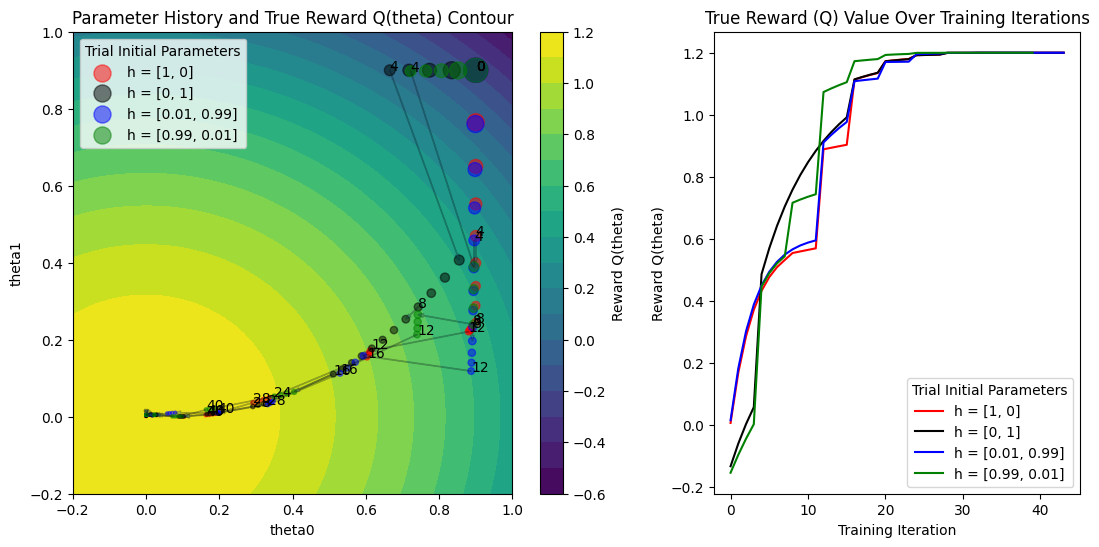

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6), gridspec_kw=dict(width_ratios=[1.5, 1]))

colors = ["red", "black", "blue", "green"]
labels = ["h = [1, 0]", "h = [0, 1]", "h = [0.01, 0.99]", "h = [0.99, 0.01]"]

plot_parameter_history(
    pbt_4_results,
    colors,
    labels,
    perturbation_interval=perturbation_interval,
    fig=fig,
    ax=axs[0],
)
plot_Q_history(pbt_4_results, colors, labels, ax=axs[1])


In [15]:
make_animation(
    pbt_4_results,
    colors,
    labels,
    perturbation_interval=perturbation_interval,
    filename="pbt4.gif",
)


![PBT 4 Trial Visualization](pbt4.gif)

## Summary

Hopefully, this guide has given you a better understanding of the PBT algorithm. Please file any issues you run into when running this notebook and ask any questions you might have in the Ray Slack